## 이 노드의 루브릭       

1. SRGAN을 통해 고해상도의 이미지를 생성하였다.(SRGAN을 통해 생성된 이미지를 제출하였다.)
2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation 생성본을 비교 분석하였다.  
(이미지의 특성과 Super Resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.)
3. 저해상도 gif 동영상을 고해상도 영상으로 성공적으로 변환하였다.   
(저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.)

## 목차           

#### 1. 직접 고른 이미지로 SRGAN 실험하기(원래 고해상도)    
- 1. Div2K의 이미지와 유사한 이미지를 골라 로드한다.
- 2. Bicubic interpolation을 적용해 가로*세로 픽셀 수를 $1/4$ 로 줄인다.    
- 3. 2에서 줄인 이미지를 SRGAN에 투입하여 고해상도 이미지를 생성한다. def apply_srgan이용   
- 4. 2의 이미지에 다시 interpolation을 적용하여 가로*세로 픽셀 수를 4배로 늘린다. intepolation
- 5. 3개 이미지(4(bicubic),3(SRGan),1(원본 이미지)를 나란히 시각화한다.(제목에 라벨링)    
- 6. 이 때, Super Resolution을 했을 때 어떤 결과가 나왔으며, 왜 그런 것 같은지를 설명한다.

---
#### 2. 직접 고른 이미지로 SRGAN 실험하기(원래 저해상도)
- 1. Div2K의 이미지와 유사한 __저해상도__ 이미지를 골라 로드한다.
- 2. SRGAN에 투입하여 고해상도 이미지를 생성한다. def apply_srgan이용   
- 3. 2의 이미지에 다시 interpolation을 적용하여 가로*세로 픽셀 수를 4배로 늘린다. intepolation
- 4. 2개 이미지(3(bicubic),2(SRGan))를 나란히 시각화한다.(제목에 라벨링)    
- 5. 이 때, Super Resolution을 했을 때 어떤 결과가 나왔으며, 왜 그런 것 같은지를 설명한다.      

---
#### 3. SRGAN을 이용해 고해상도 gif 생성하기      
- 한 프레임씩 고해상도 이미지로 변환시켜 모든 프레임에 적용하고, 그 프레임을 합쳐 동영상으로 만들어본다.

1. gif 파일 불러오기       
2. 프레임별 Super Resolution 적용하기      
3. 프레임을 합쳐 gif 만들기  
4. jupyter notebook에 gif 표시하기

## 1. 직접 고른 이미지로 SRGAN 실험하기     

### 1. Div2K의 이미지와 유사한 이미지를 골라 로드한다.        

- 풍경이나 사물을 주제로 한 고화질 이미지를 찾아 로드한다.

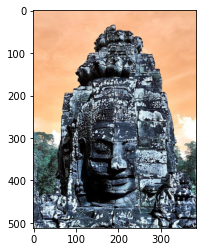

In [14]:
import os

import cv2
import matplotlib.pyplot as plt

image_file = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex16_SRCNN/Image/ancor.jpg'

origin = cv2.imread(image_file)
plt.imshow(origin)
plt.show()

### 2. bicubic을 이용해 고화질 이미지의 가로*세로 픽셀수를 $1/4$로 줄인다.

In [10]:
print('이미지 크기 : ', origin.shape)

이미지 크기 :  (512, 384, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


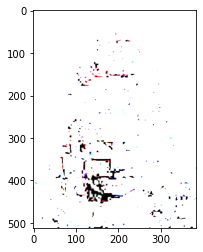

In [15]:
import tensorflow as tf

origin_x4 = tf.image.resize(origin, [512//4, 384//4], "bicubic")
origin_x4 = tf.image.resize(origin_x4, [512,384], "bicubic")

plt.imshow(origin_x4)

### 3. SRGAN 생성

In [16]:
# srgan을 위해 이미지 중 일부를 잘라낼 함수를 설정

In [17]:
def srgan_preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32)/255
    
    #이미지 중 랜덤으로 96,96 사이즈의 크기를 잘라낸다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
    
    #잘라낸 이미지를 1/4로 줄이고, 이를 입력으로 쓴다.
    #(원래는 이러지 않는다구...)
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    
    return lr_patch, hr_patch

#### SRGAN의 Generator 구현

In [18]:
from tensorflow.keras import Input, Model

#파란색 블록, Conv레이어를 만듦
def generate_base_block(x):
    out = layers.Conv2D(64,3,1,"same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64,3,1,"same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

#연두색 블록, Sum이라는데..
def upsample_block(x):
    out = layers.Conv2D(256,3,1,"same")(x)
    
    #그림의 pixelshuffle을 코드화
    out = layers.Lambda(lambda x : tf.nn.depth_to_space(x,2))(out)
    
    return layers.PReLU(shared_axes=[1,2])(out)

In [19]:
#전체 Generator 정의
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64,9,1,"same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = generate_base_block(out)
        
    out = layers.Conv2D(64,3,1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3,9,1, "same", activation="tanh")(out)
    return Model(inputs, out)

print('제너레이터 세팅 완료')

제너레이터 세팅 완료


#### SRGAN의 Discriminator 구현

In [20]:
def discriminator_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = discriminator_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print('판별자 세팅 완료')

판별자 세팅 완료


#### SRGAN의 loss를 구하기 위한 함수 구현

In [21]:
from tensorflow.python.keras import applications

#VGG를 이용해 특징을 빼내고, 이걸로 loss를 계산하므로 이름을 이렇게 짓는다.
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape)
    
    return Model(vgg.input, vgg.layers[20].output)

print('loss용 피쳐 extractor')

loss용 피쳐 extractor


### SRGAN 학습하기

In [22]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()
    
print('all setting 완료')

NameError: name 'layers' is not defined